In [1]:
from time import perf_counter
import numpy as np
# import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import src.utils as utils
from src.model import Nonneg_dagma, MetMulDagma

from baselines.colide import colide_ev
from baselines.dagma_linear import DAGMA_linear
from baselines.notears import notears_linear


PATH = './results/size/'
SAVE = True 
SEED = 10
N_CPUS = os.cpu_count()
np.random.seed(SEED)

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Auxiliary functions

In [2]:
# Experiment function
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def run_size_exp(g, data_p, Sizes, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = [np.zeros((len(Sizes), len(exps)))  for _ in range(8)]
    for i, n_nodes in enumerate(Sizes):
        print(f'(G={g+1}, N={n_nodes})', end=' ')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['n_nodes'] = n_nodes
        data_p_aux['edges'] *= n_nodes
        data_p_aux['var'] = 1/np.sqrt(n_nodes) if data_p_aux['var'] is None else data_p_aux['var']
        data_p_aux['n_samples'] = 10*n_nodes if data_p_aux['n_samples'] is None else data_p_aux['n_samples']

        W_true, _, X = utils.simulate_sem(**data_p_aux)
        X_std = utils.standarize(X)
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)

        for j, exp in enumerate(exps):
            X_aux = X_std if 'standarize' in exp.keys() and exp['standarize'] else X


            arg_aux = exp['args'].copy()
            if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
                if 'lamb' in arg_aux.keys():
                    arg_aux['lamb'] = get_lamb_value(n_nodes, data_p_aux['n_samples'], arg_aux['lamb'])
                elif 'lambda1' in arg_aux.keys():
                    arg_aux['lambda1'] = get_lamb_value(n_nodes, data_p_aux['n_samples'], arg_aux['lambda1'])

            if exp['model'] == notears_linear:
                t_init = perf_counter()
                W_est = notears_linear(X_aux, **arg_aux)
                t_end = perf_counter()
            else:
                model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
                t_init = perf_counter()
                model.fit(X_aux, **arg_aux)
                t_end = perf_counter()
                
                W_est = model.W_est

            if np.isnan(W_est).any():
                W_est = np.zeros_like(W_est)
                W_est_bin = np.zeros_like(W_est)
            else:
                W_est_bin = utils.to_bin(W_est, thr)
            
            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
            acyc[i,j] = model.dagness(W_est) if hasattr(model, 'dagness') else 1
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb:
                print(f'\n\t\t-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, acyc, runtime, dag_count

In [3]:
n_dags = 25
Sizes = [50, 100, 500]

# DEFINE EXPERIMENTS
Exps = [
  # Convex
  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
   'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-Logdet'},

  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .05,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
   'adapt_lamb': False, 'standarize': False, 'fmt': 'o--', 'leg': 'MM-Logdet-fix'},

  # Colide
  # {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
  #  'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v-', 'leg': 'CoLiDe-Fix'},

  # {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
  #  'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'adapt_lamb': True, 'fmt': 'v-', 'leg': 'CoLiDe'},

  # DAGMA
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': '^-', 'leg': 'DAGMA'},
]

## 4N Edges

### Erdos Renyi

In [4]:
thr = .2
verb = False
data_p = {
    'graph_type': 'er',
    'edges': 4,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
    'n_samples': 1000,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_er4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

CPUs employed: 64


Graph: 9, n_nodes: 50
Graph: 7, n_nodes: 50
Graph: 8, n_nodes: 50
Graph: 6, n_nodes: 50
Graph: 11, n_nodes: 50
Graph: 15, n_nodes: 50
Graph: 14, n_nodes: 50
Graph: 21, n_nodes: 50
Graph: 2, n_nodes: 50
Graph: 12, n_nodes: 50
Graph: 4, n_nodes: 50
Graph: 23, n_nodes: 50
Graph: 17, n_nodes: 50
Graph: 1, n_nodes: 50
Graph: 16, n_nodes: 50
Graph: 20, n_nodes: 50
Graph: 18, n_nodes: 50
Graph: 25, n_nodes: 50
Graph: 24, n_nodes: 50
Graph: 22, n_nodes: 50
Graph: 19, n_nodes: 50
Graph: 5, n_nodes: 50
Graph: 3, n_nodes: 50
Graph: 10, n_nodes: 50Graph: 13, n_nodes: 50

Graph: 10, n_nodes: 100
Graph: 12, n_nodes: 100
Graph: 24, n_nodes: 100
Graph: 19, n_nodes: 100
Graph: 25, n_nodes: 100
Graph: 22, n_nodes: 100
Graph: 4, n_nodes: 100
Graph: 14, n_nodes: 100
Graph: 16, n_nodes: 100
Graph: 13, n_nodes: 100
Graph: 5, n_nodes: 100
Graph: 8, n_nodes: 100
Graph: 2, n_nodes: 100
Graph: 20, n_nodes: 100
Graph: 9, n_nodes: 100
Graph: 1, n_nodes: 100
Graph: 17, n_nodes: 100
Graph: 11, n_nodes: 100
Graph: 2

SAVED in file: ./results/size/size_ERgraph_4N


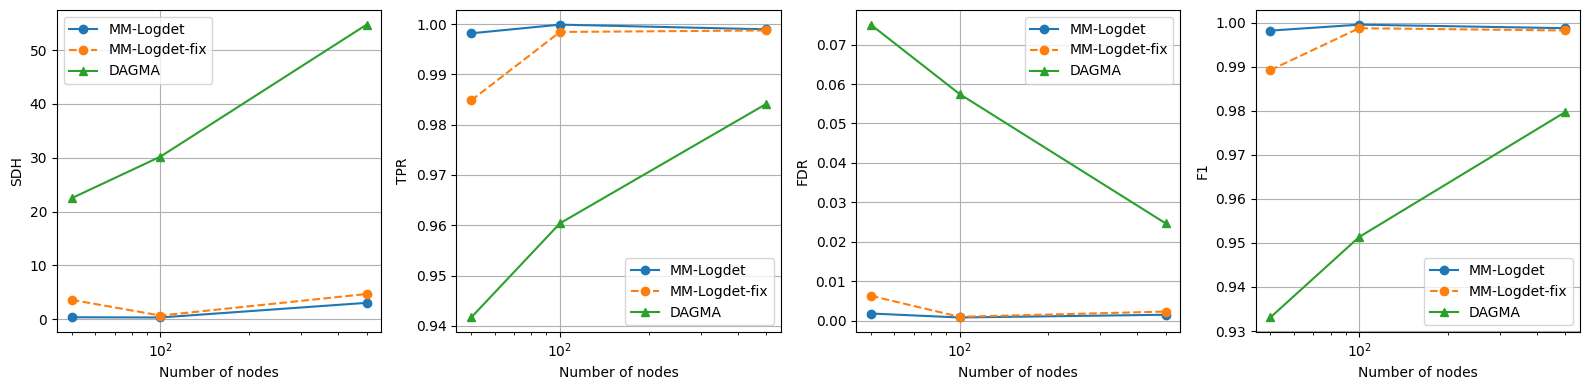

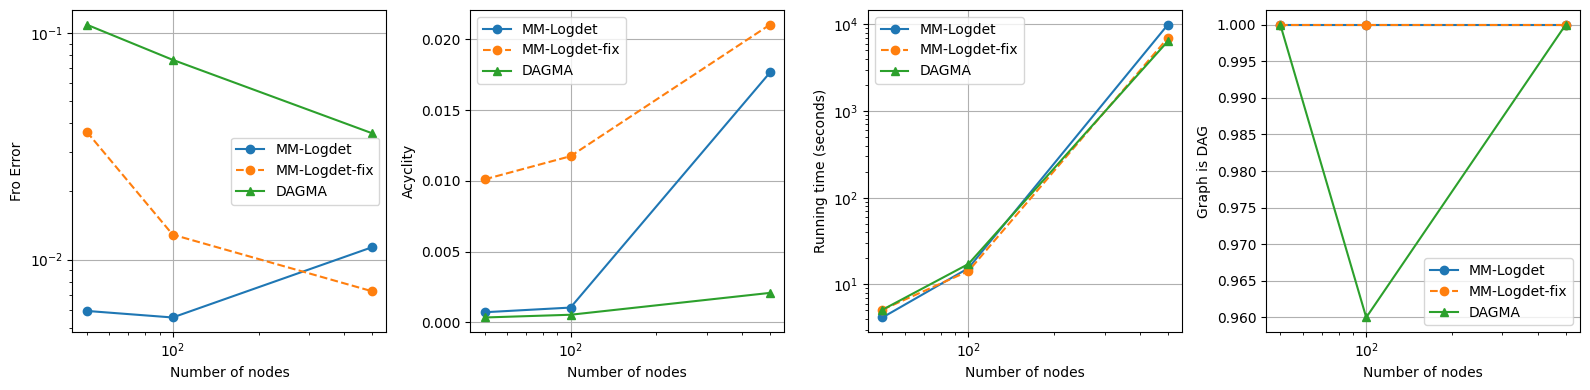

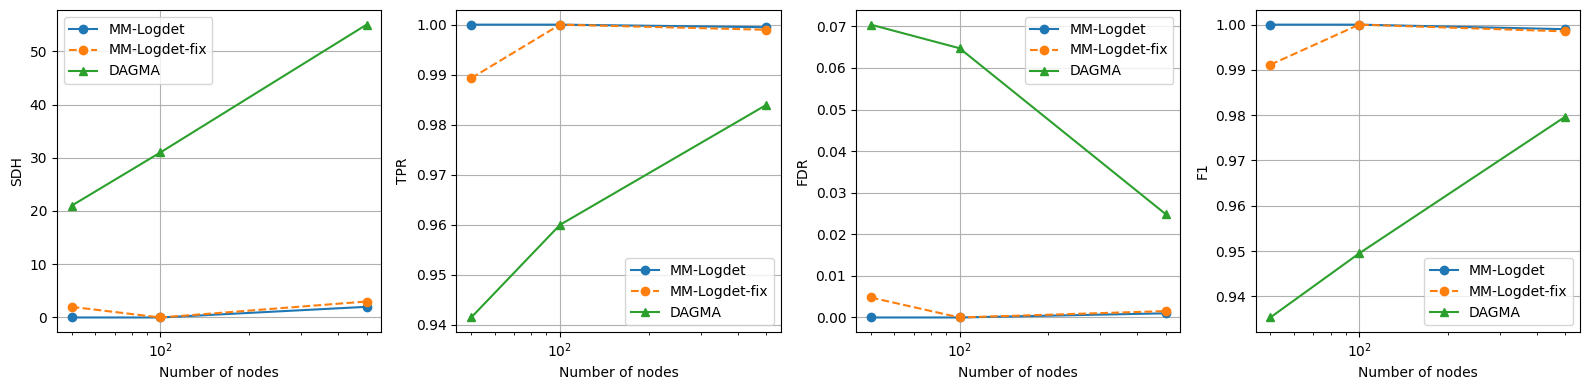

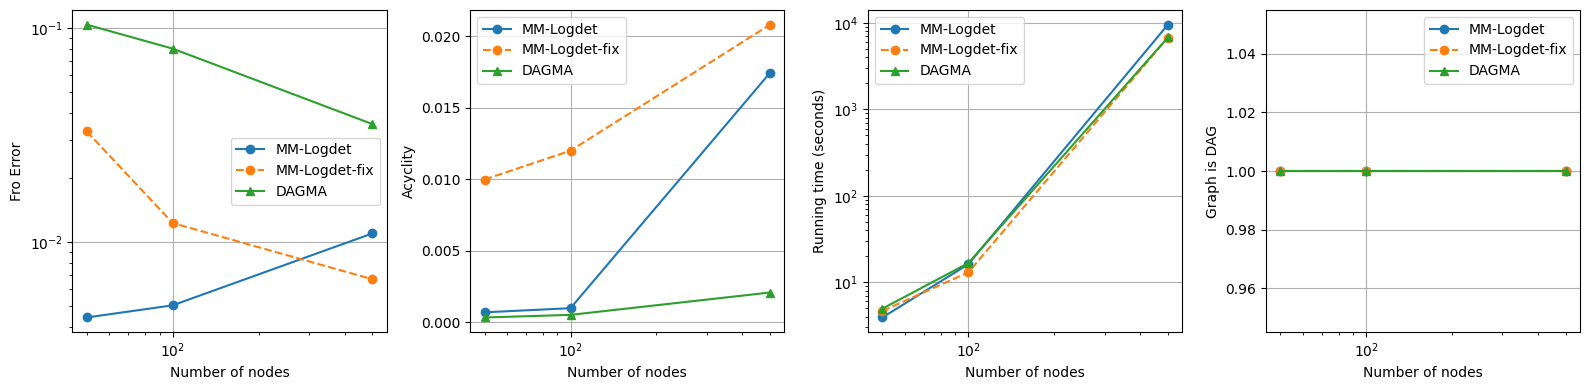

In [5]:
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results_er4)

if SAVE:
    file_name = PATH + f'size_ERgraph_{data_p["edges"]}N'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='mean', xlabel='Number of nodes')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')


### Scale free

In [6]:
N = 100
thr = .2
verb = False
data_p = {
    # 'n_nodes': N,
    'graph_type': 'sf',
    'edges': 4,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
    'n_samples': 1000,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_sf4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

CPUs employed: 64
Graph: 1, n_nodes: 50


Graph: 4, n_nodes: 50
Graph: 8, n_nodes: 50
Graph: 11, n_nodes: 50
Graph: 12, n_nodes: 50
Graph: 7, n_nodes: 50
Graph: 9, n_nodes: 50
Graph: 16, n_nodes: 50
Graph: 2, n_nodes: 50
Graph: 14, n_nodes: 50
Graph: 22, n_nodes: 50
Graph: 24, n_nodes: 50
Graph: 3, n_nodes: 50
Graph: 13, n_nodes: 50
Graph: 10, n_nodes: 50
Graph: 15, n_nodes: 50
Graph: 18, n_nodes: 50
Graph: 5, n_nodes: 50
Graph: 6, n_nodes: 50
Graph: 17, n_nodes: 50
Graph: 23, n_nodes: 50
Graph: 25, n_nodes: 50
Graph: 21, n_nodes: 50
Graph: 20, n_nodes: 50
Graph: 19, n_nodes: 50
Graph: 1, n_nodes: 100
Graph: 15, n_nodes: 100
Graph: 4, n_nodes: 100
Graph: 11, n_nodes: 100
Graph: 3, n_nodes: 100
Graph: 18, n_nodes: 100
Graph: 7, n_nodes: 100
Graph: 2, n_nodes: 100
Graph: 19, n_nodes: 100
Graph: 20, n_nodes: 100
Graph: 22, n_nodes: 100
Graph: 16, n_nodes: 100
Graph: 10, n_nodes: 100
Graph: 23, n_nodes: 100
Graph: 5, n_nodes: 100
Graph: 8, n_nodes: 100
Graph: 12, n_nodes: 100
Graph: 9, n_nodes: 100
Graph: 25, n_nodes: 100
Graph: 1

SAVED in file: ./results/size/size_SFgraph_4N


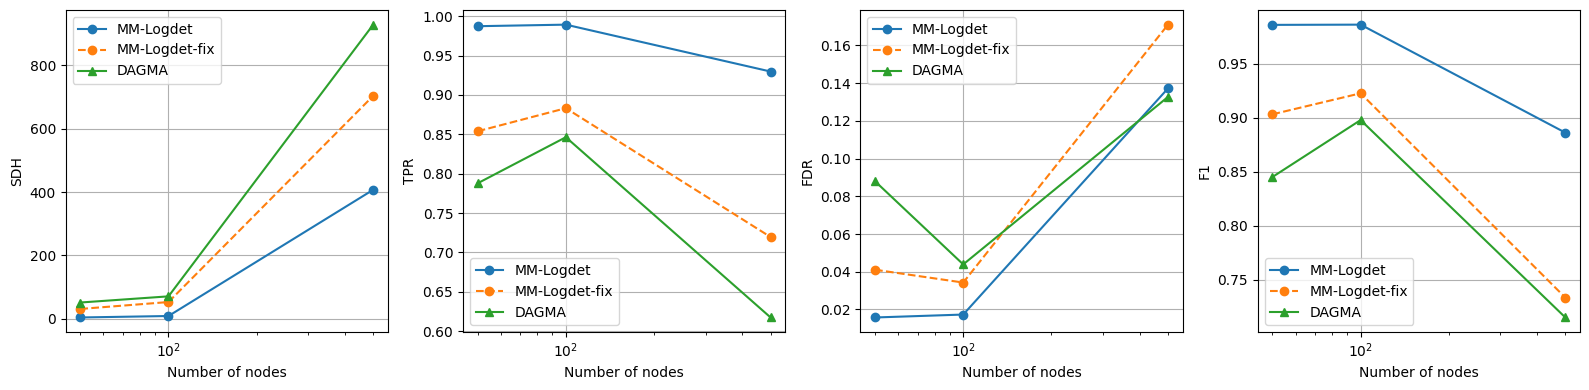

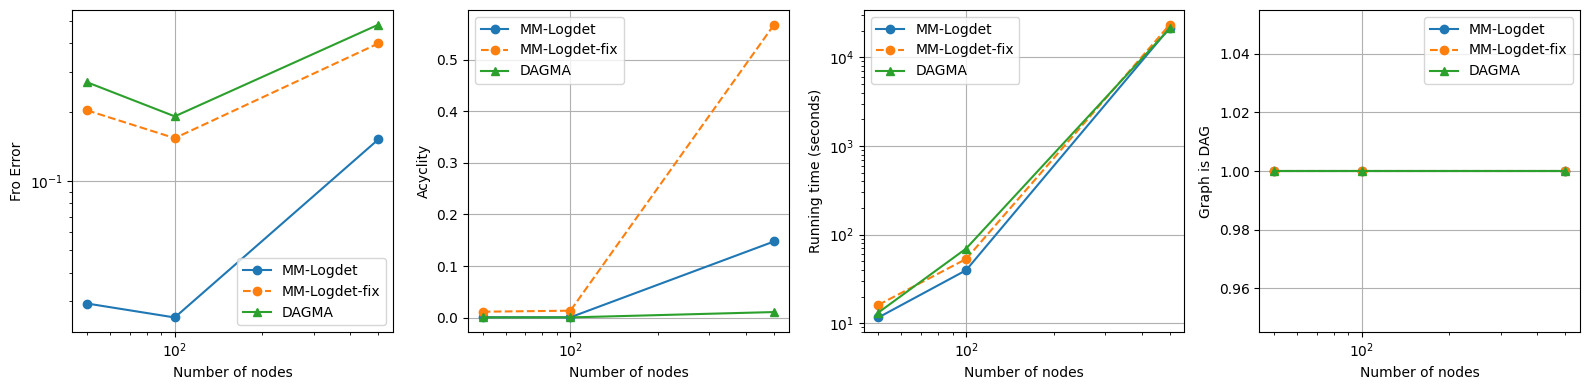

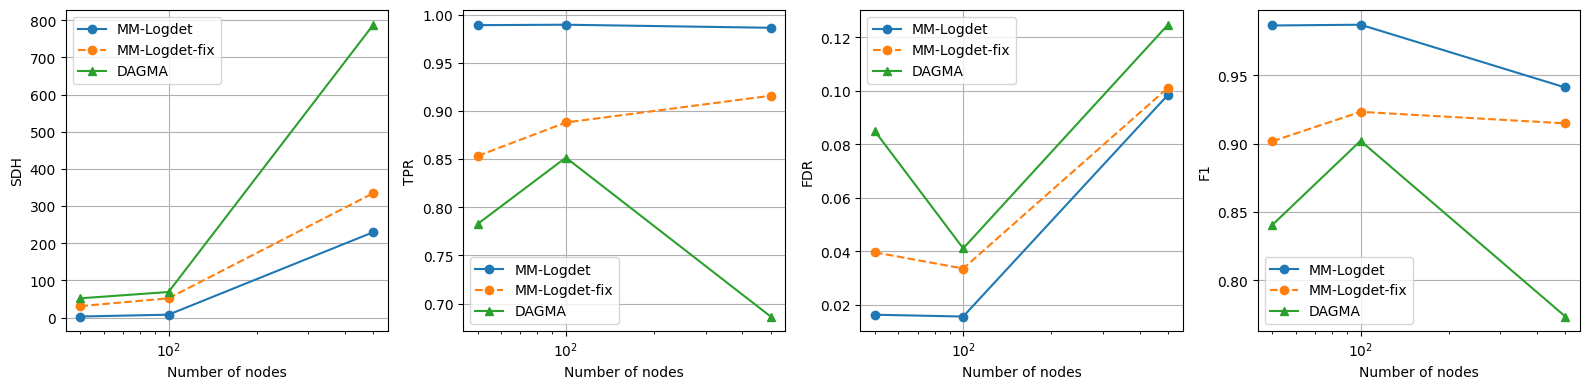

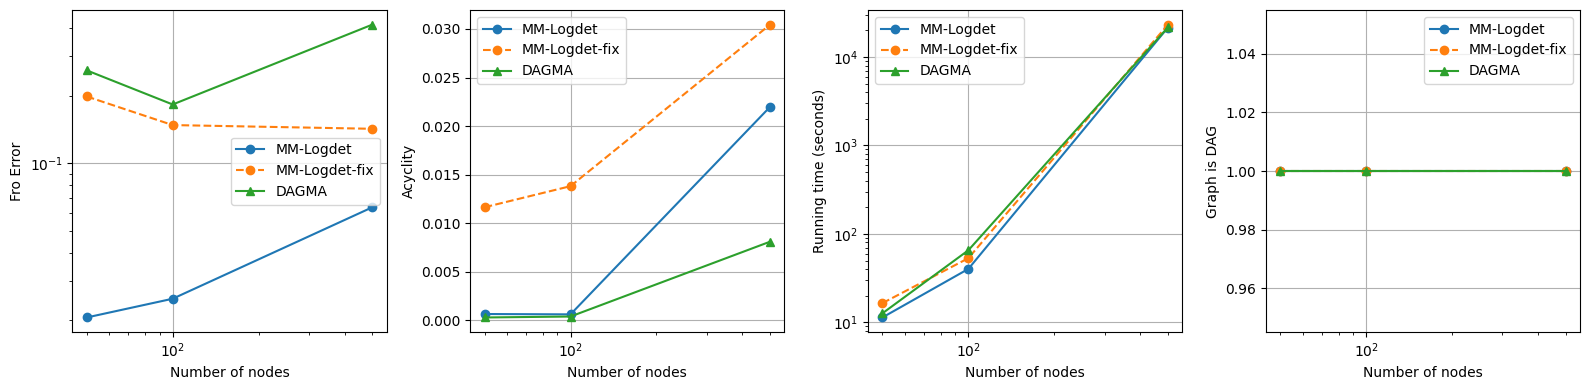

In [7]:
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results_sf4)

if SAVE:
    file_name = PATH + f'size_SFgraph_{data_p["edges"]}N'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='mean', xlabel='Number of nodes')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')


In [8]:
# SF TRANSPOSE!
N = 100
thr = .2
verb = False
data_p = {
    # 'n_nodes': N,
    'graph_type': 'sf_t',
    'edges': 4,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
    'n_samples': 1000,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_sf4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

CPUs employed: 64
Graph: 1, n_nodes: 50
Graph: 2, n_nodes: 50
Graph: 3, n_nodes: 50
Graph: 4, n_nodes: 50
Graph: 5, n_nodes: 50
Graph: 6, n_nodes: 50
Graph: 7, n_nodes: 50
Graph: 25, n_nodes: 50
Graph: 14, n_nodes: 50
Graph: 12, n_nodes: 50
Graph: 23, n_nodes: 50
Graph: 9, n_nodes: 50Graph: 18, n_nodes: 50

Graph: 17, n_nodes: 50
Graph: 10, n_nodes: 50
Graph: 11, n_nodes: 50
Graph: 8, n_nodes: 50
Graph: 13, n_nodes: 50
Graph: 15, n_nodes: 50
Graph: 16, n_nodes: 50
Graph: 24, n_nodes: 50
Graph: 20, n_nodes: 50
Graph: 19, n_nodes: 50
Graph: 21, n_nodes: 50
Graph: 22, n_nodes: 50
Graph: 25, n_nodes: 100
Graph: 9, n_nodes: 100
Graph: 12, n_nodes: 100
Graph: 7, n_nodes: 100
Graph: 13, n_nodes: 100
Graph: 1, n_nodes: 100
Graph: 16, n_nodes: 100
Graph: 6, n_nodes: 100
Graph: 23, n_nodes: 100
Graph: 19, n_nodes: 100
Graph: 10, n_nodes: 100
Graph: 4, n_nodes: 100
Graph: 18, n_nodes: 100
Graph: 14, n_nodes: 100
Graph: 3, n_nodes: 100
Graph: 2, n_nodes: 100
Graph: 15, n_nodes: 100
Graph: 20, n_no

SAVED in file: ./results/size/size_SFgraph_4N


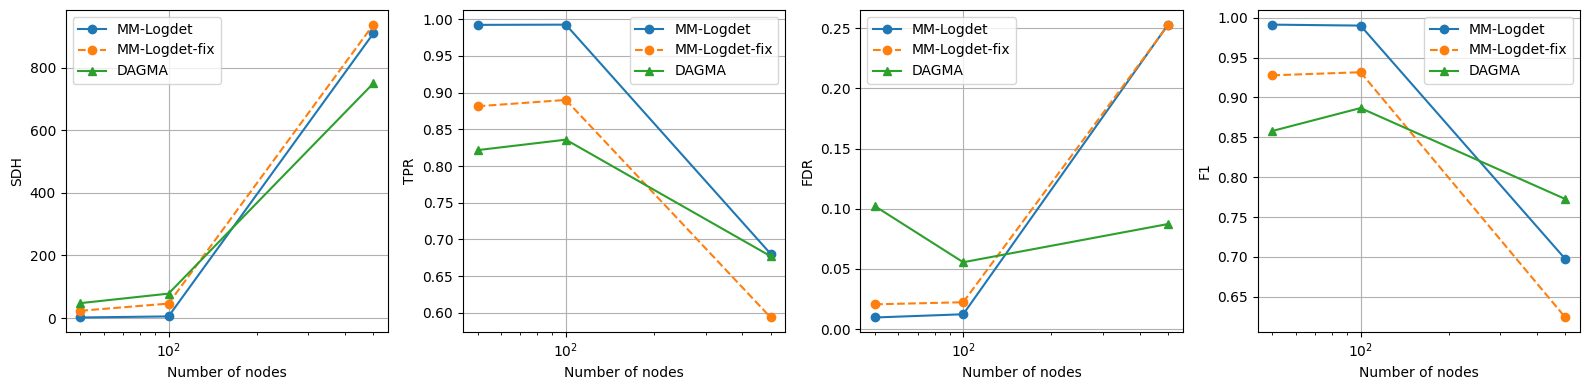

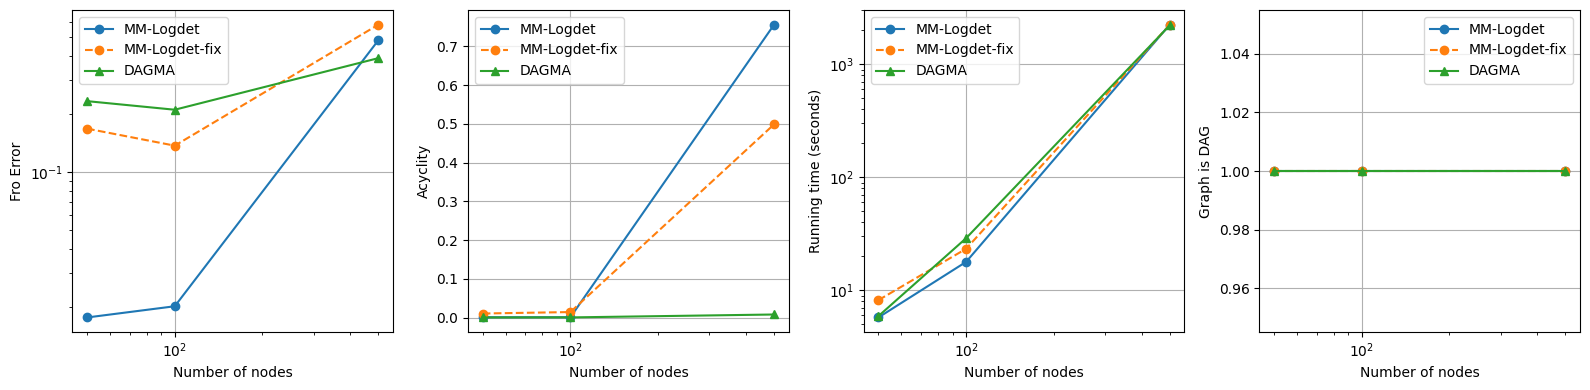

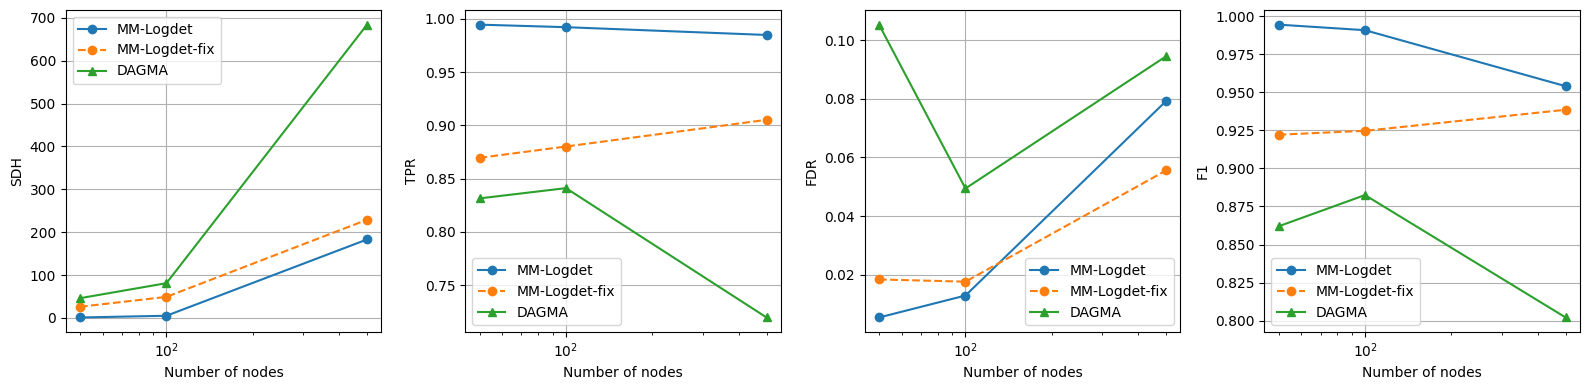

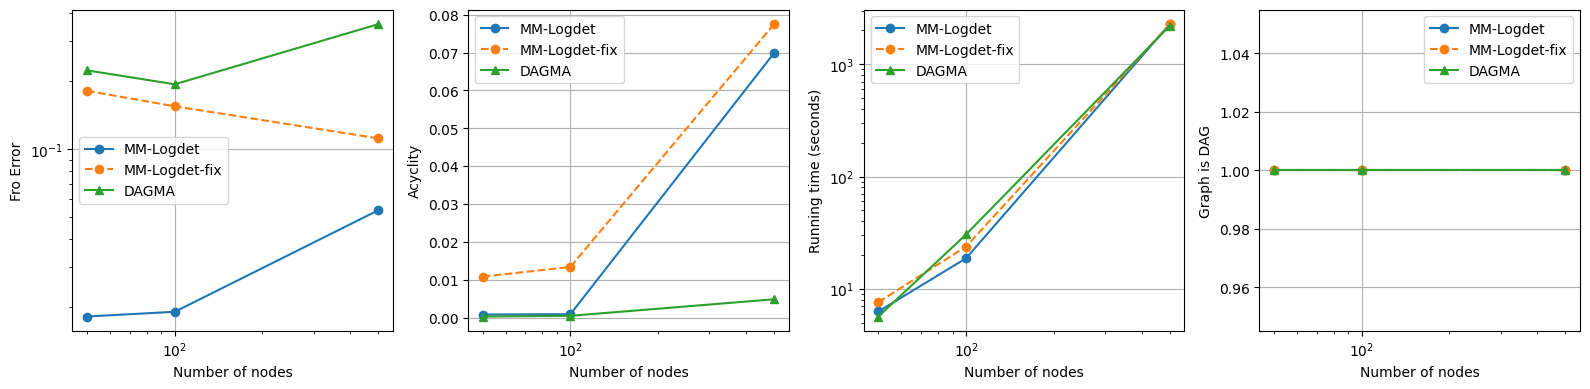

In [ ]:
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results_sf4)

if SAVE:
    file_name = PATH + f'size_SFTgraph_{data_p["edges"]}N'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='mean', xlabel='Number of nodes')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')


## Constant varianze

### Erdos Renyi

In [8]:
thr = .2
verb = False
data_p = {
    'graph_type': 'er',
    'edges': 2,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': None,
    'n_samples': 1000,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_er4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

CPUs employed: 64
Graph: 1, n_nodes: 50
Graph: 2, n_nodes: 50
Graph: 3, n_nodes: 50
Graph: 4, n_nodes: 50
Graph: 5, n_nodes: 50
Graph: 2, n_nodes: 100
Graph: 3, n_nodes: 100
Graph: 5, n_nodes: 100
Graph: 1, n_nodes: 100
Graph: 4, n_nodes: 100
Graph: 2, n_nodes: 500
Graph: 4, n_nodes: 500
Graph: 5, n_nodes: 500
Graph: 3, n_nodes: 500
Graph: 1, n_nodes: 500
----- Solved in 61.456 minutes -----


SAVED in file: ./results/size/size_ERgraph_2N_const_var


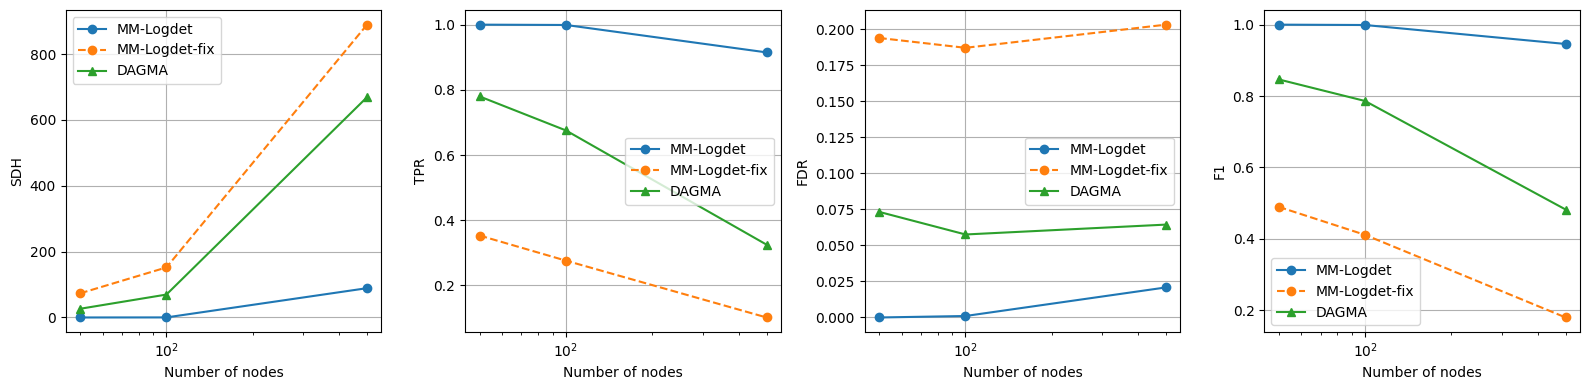

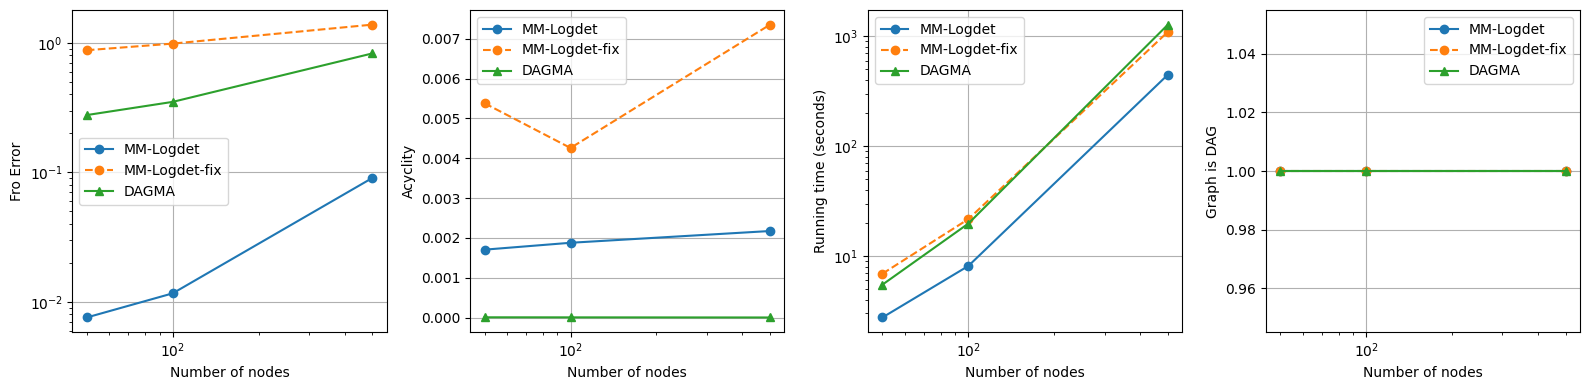

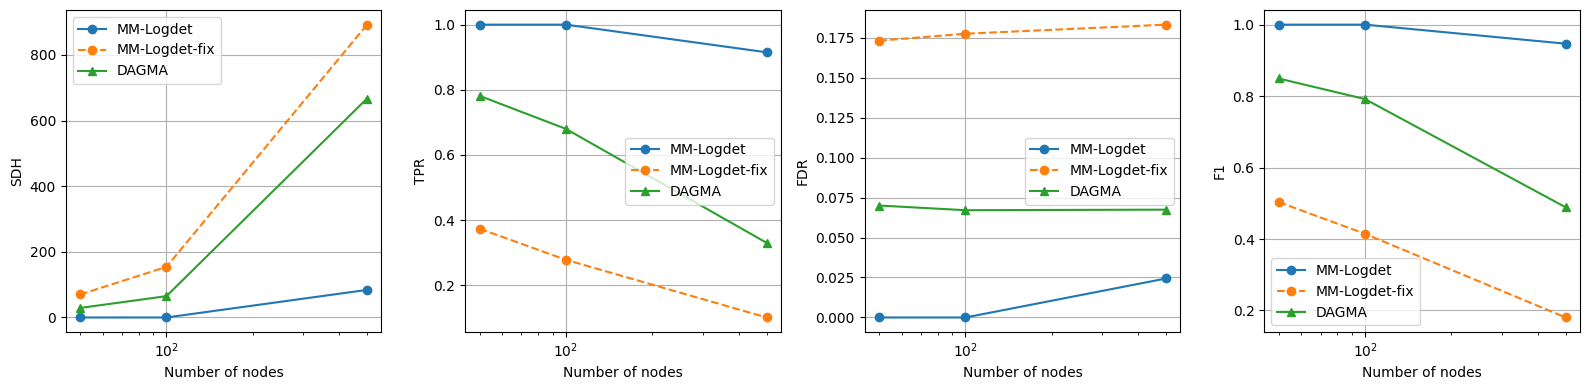

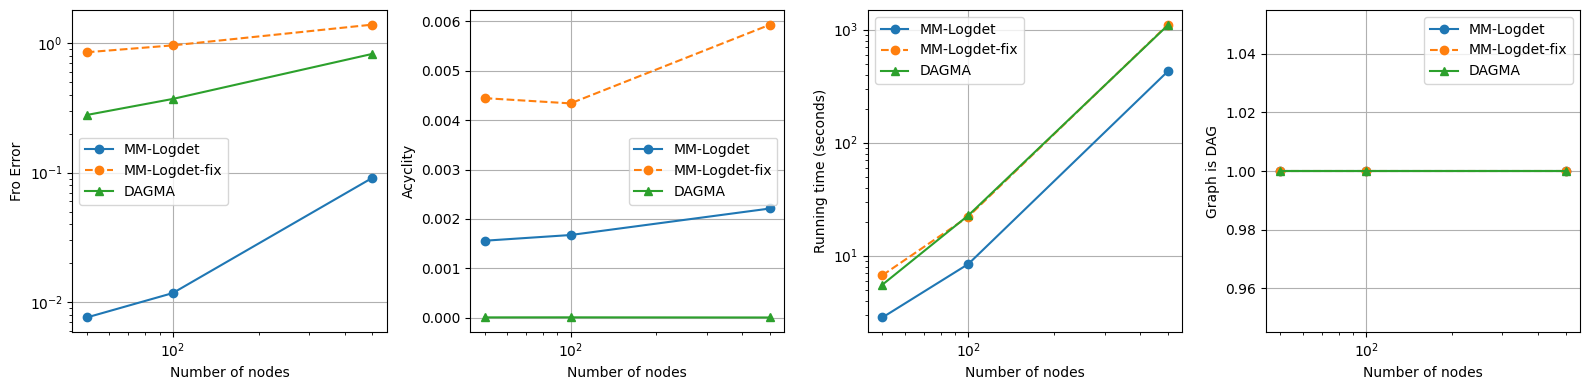

In [9]:
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results_er4)

if SAVE:
    file_name = PATH + f'size_ERgraph_{data_p["edges"]}N_const_var'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='mean', xlabel='Number of nodes')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')


### Scale free

In [10]:
N = 100
thr = .2
verb = False
data_p = {
    # 'n_nodes': N,
    'graph_type': 'sf',
    'edges': 4,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': None,
    'n_samples': 1000,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_sf4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

CPUs employed: 64
Graph: 1, n_nodes: 50
Graph: 4, n_nodes: 50
Graph: 2, n_nodes: 50
Graph: 3, n_nodes: 50
Graph: 5, n_nodes: 50
Graph: 1, n_nodes: 100
Graph: 3, n_nodes: 100
Graph: 2, n_nodes: 100
Graph: 5, n_nodes: 100
Graph: 4, n_nodes: 100
Graph: 1, n_nodes: 500
Graph: 4, n_nodes: 500
Graph: 5, n_nodes: 500
Graph: 3, n_nodes: 500
Graph: 2, n_nodes: 500
----- Solved in 115.562 minutes -----


SAVED in file: ./results/size/size_SFgraph_4N_const_var


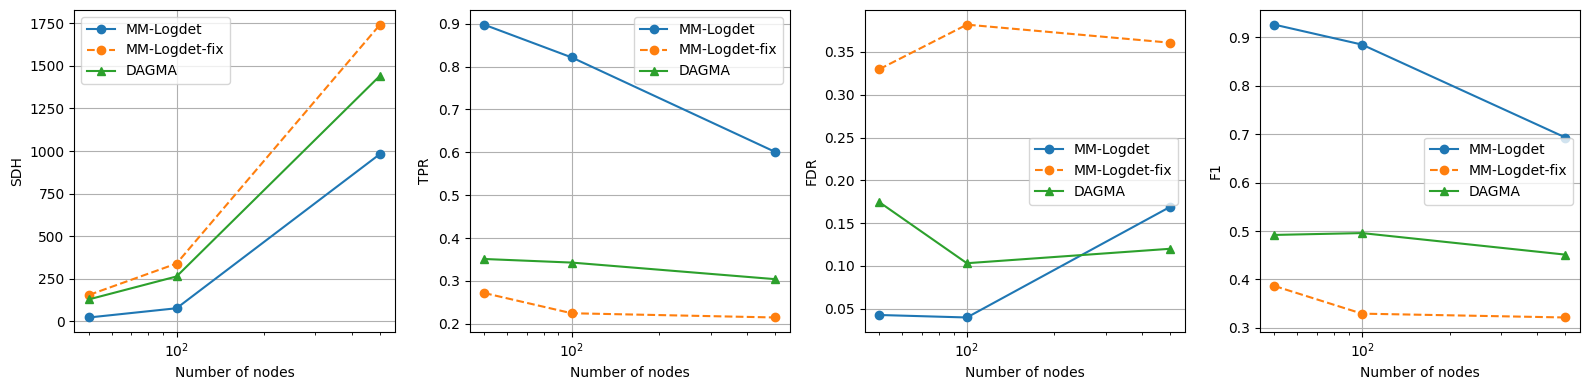

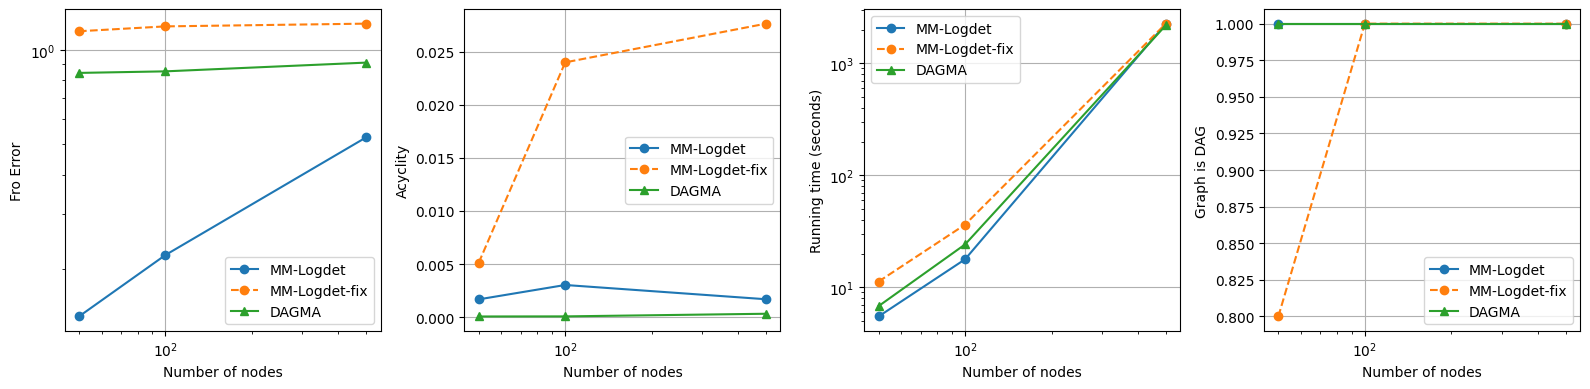

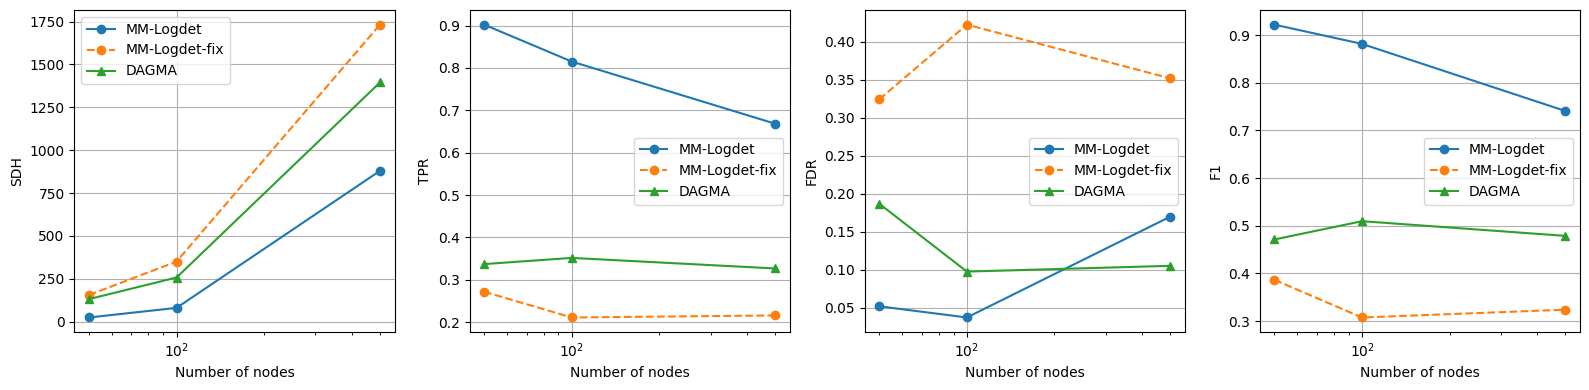

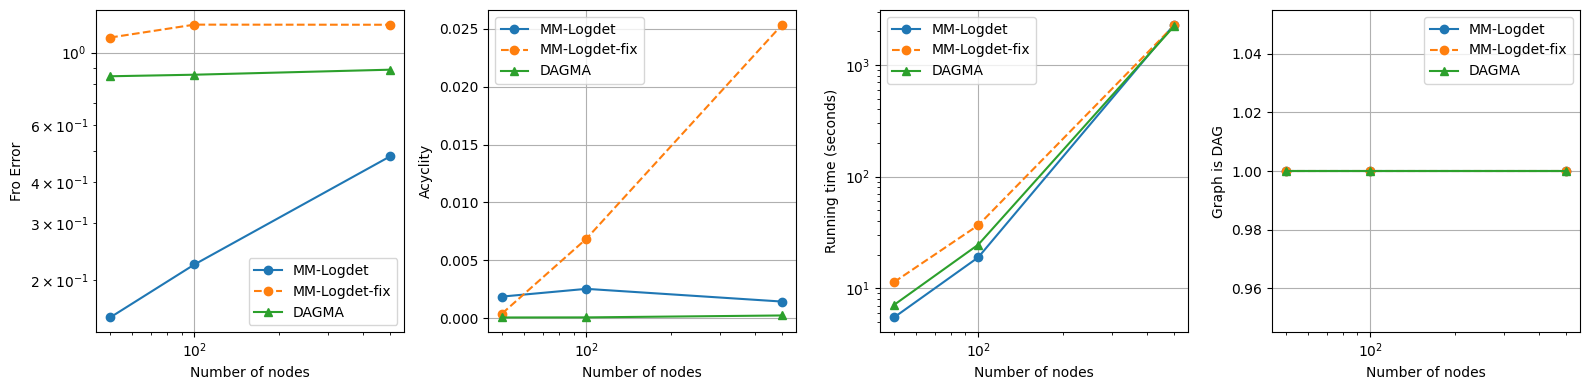

In [11]:
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results_sf4)

if SAVE:
    file_name = PATH + f'size_SFgraph_{data_p["edges"]}N_const_var'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='mean', xlabel='Number of nodes')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')


## 2N Edges

### Erdos Renyi

In [12]:
thr = .2
verb = False
data_p = {
    'graph_type': 'er',
    'edges': 2,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
    'n_samples': 1000,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_er4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

CPUs employed: 64
Graph: 1, n_nodes: 50
Graph: 2, n_nodes: 50
Graph: 3, n_nodes: 50
Graph: 4, n_nodes: 50
Graph: 5, n_nodes: 50
Graph: 5, n_nodes: 100
Graph: 4, n_nodes: 100
Graph: 1, n_nodes: 100
Graph: 2, n_nodes: 100
Graph: 3, n_nodes: 100
Graph: 5, n_nodes: 500
Graph: 3, n_nodes: 500
Graph: 2, n_nodes: 500
Graph: 4, n_nodes: 500
Graph: 1, n_nodes: 500
----- Solved in 35.139 minutes -----


SAVED in file: ./results/size/size_ERgraph_2N


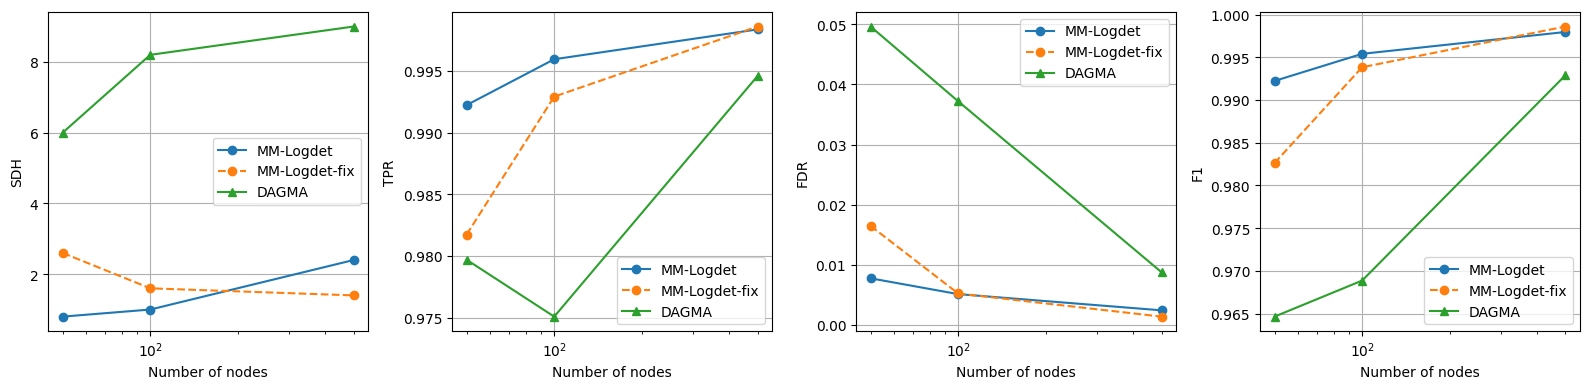

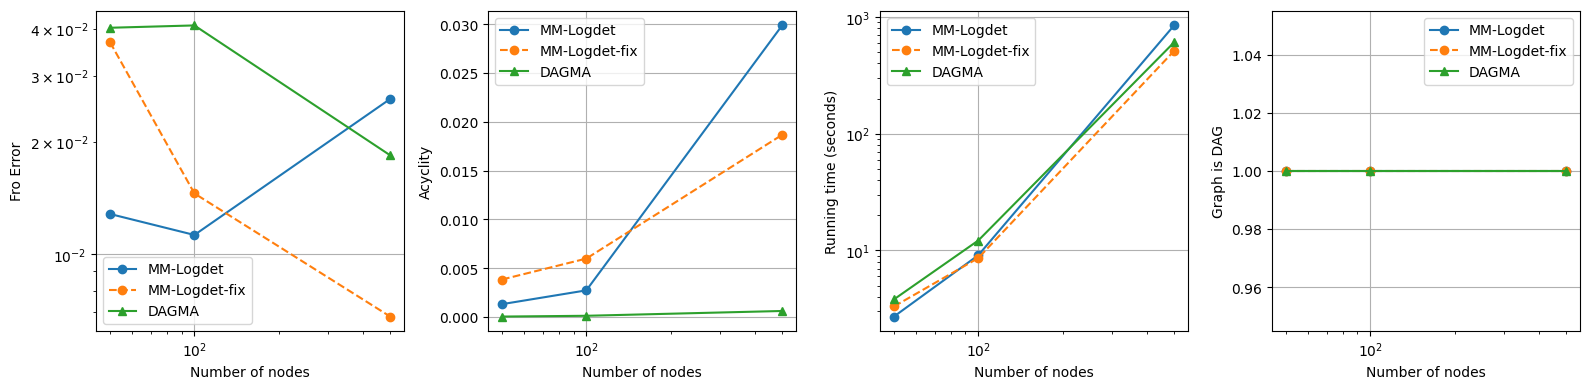

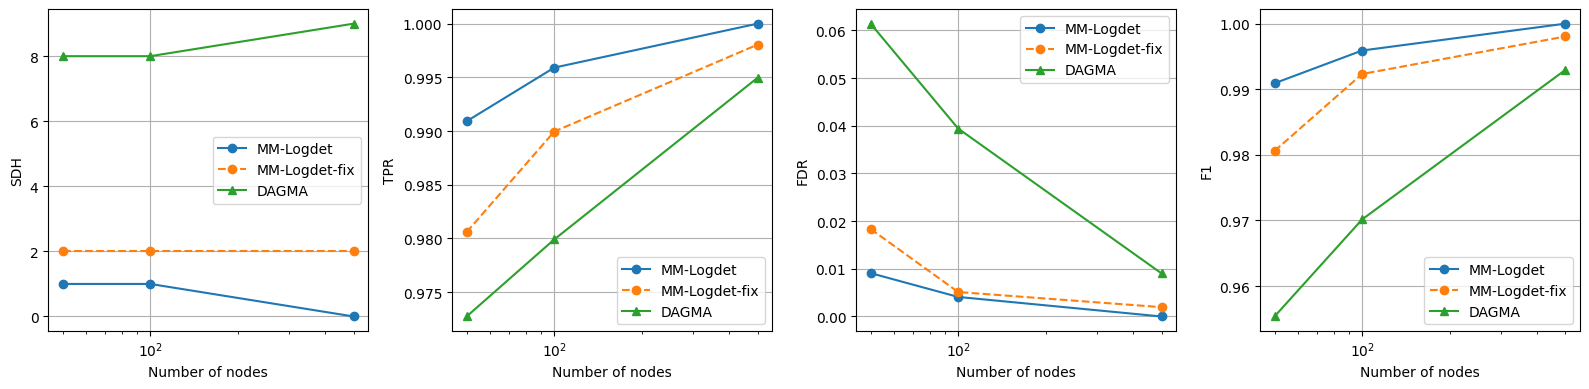

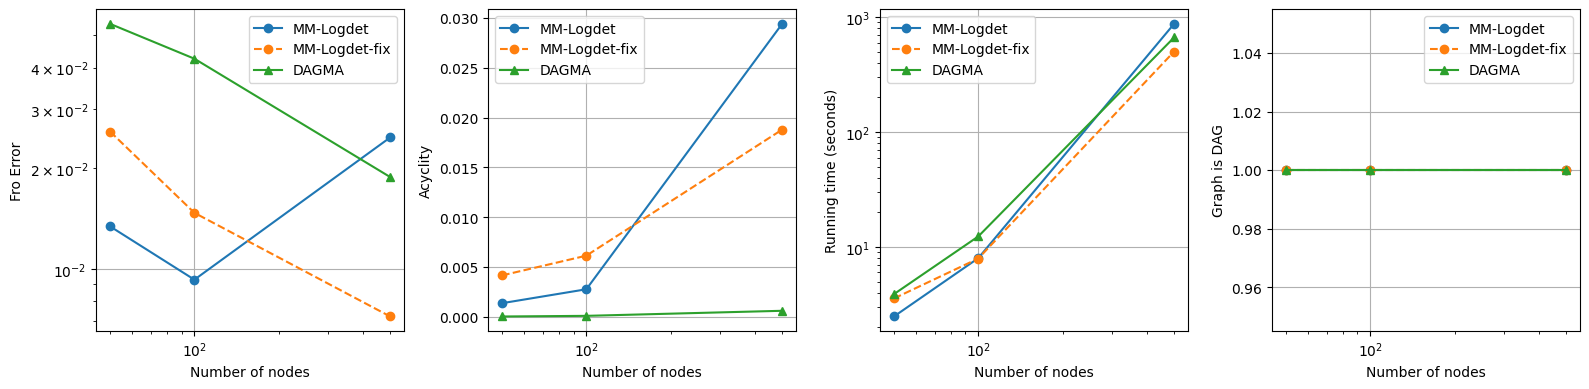

In [13]:
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results_er4)

if SAVE:
    file_name = PATH + f'size_ERgraph_{data_p["edges"]}N'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='mean', xlabel='Number of nodes')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')


### Scale free

In [14]:
N = 100
thr = .2
verb = False
data_p = {
    # 'n_nodes': N,
    'graph_type': 'sf',
    'edges': 2,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
    'n_samples': 1000,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_sf4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

CPUs employed: 64
Graph: 1, n_nodes: 50
Graph: 2, n_nodes: 50
Graph: 3, n_nodes: 50
Graph: 4, n_nodes: 50
Graph: 5, n_nodes: 50
Graph: 1, n_nodes: 100
Graph: 3, n_nodes: 100
Graph: 5, n_nodes: 100
Graph: 2, n_nodes: 100
Graph: 4, n_nodes: 100
Graph: 1, n_nodes: 500
Graph: 4, n_nodes: 500
Graph: 5, n_nodes: 500
Graph: 3, n_nodes: 500
Graph: 2, n_nodes: 500
----- Solved in 59.245 minutes -----


SAVED in file: ./results/size/size_SFgraph_2N


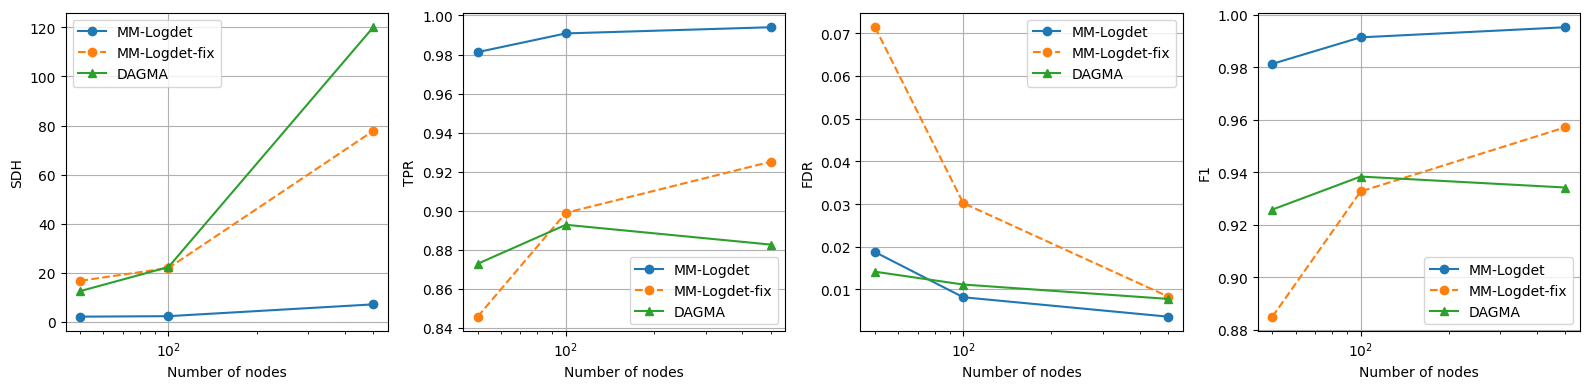

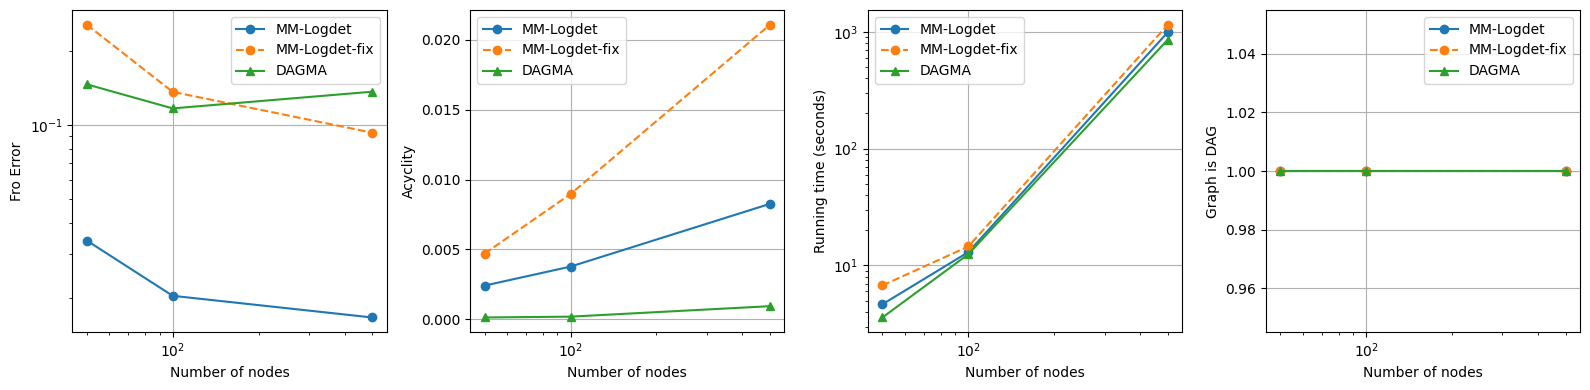

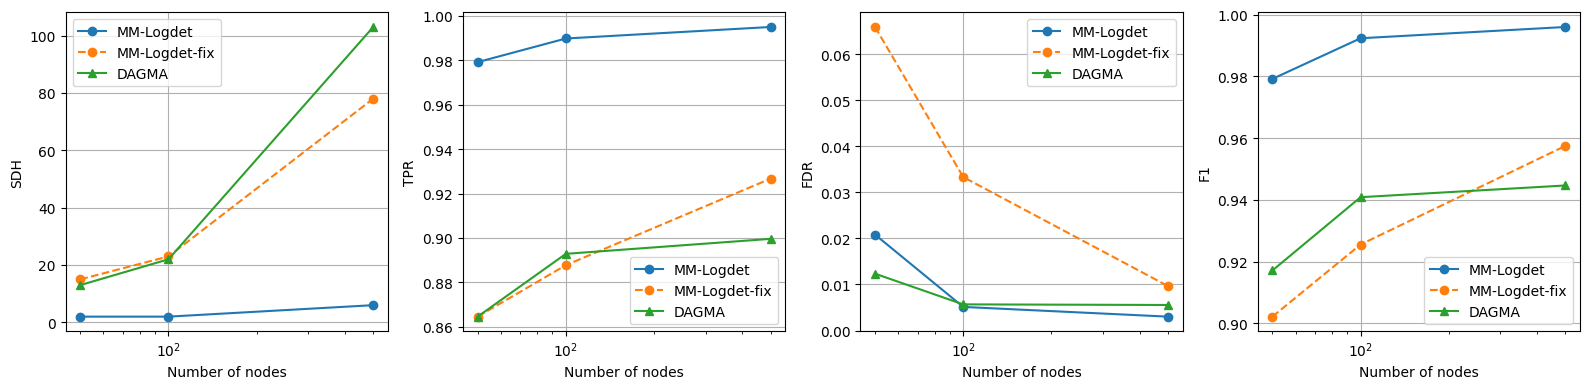

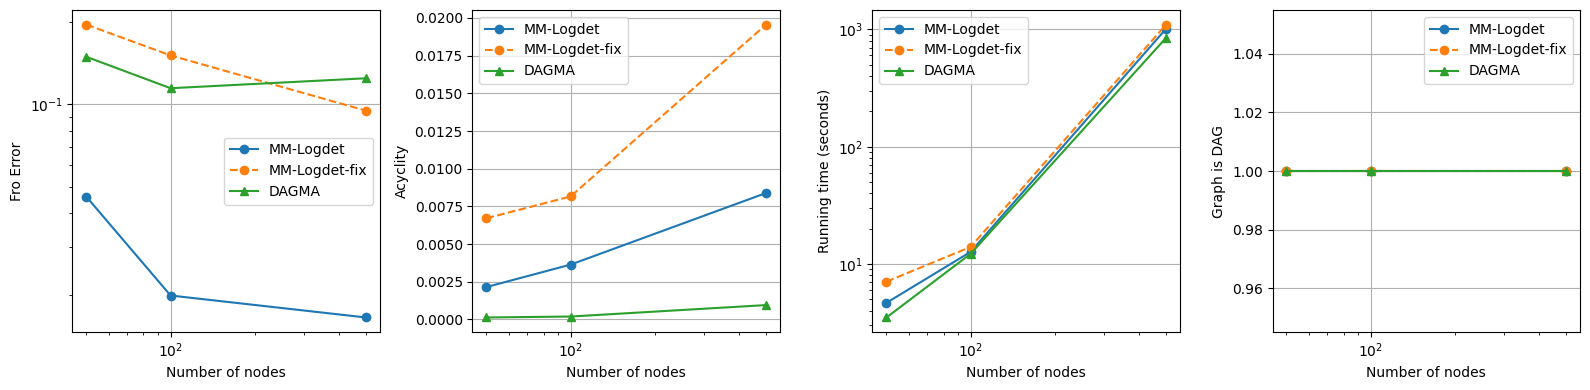

In [15]:
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results_sf4)

if SAVE:
    file_name = PATH + f'size_SFgraph_{data_p["edges"]}N'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='mean', xlabel='Number of nodes')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')


## Constant samples

### Erdos Renyi

In [ ]:
thr = .2
verb = False
data_p = {
    'graph_type': 'er',
    'edges': 4,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
    'n_samples': None,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_er4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

CPUs employed: 64
Graph: 4, n_nodes: 50
Graph: 5, n_nodes: 50
Graph: 21, n_nodes: 50
Graph: 13, n_nodes: 50
Graph: 11, n_nodes: 50
Graph: 15, n_nodes: 50
Graph: 24, n_nodes: 50
Graph: 3, n_nodes: 50
Graph: 17, n_nodes: 50
Graph: 22, n_nodes: 50
Graph: 6, n_nodes: 50
Graph: 12, n_nodes: 50
Graph: 18, n_nodes: 50
Graph: 19, n_nodes: 50
Graph: 25, n_nodes: 50
Graph: 8, n_nodes: 50
Graph: 23, n_nodes: 50
Graph: 9, n_nodes: 50
Graph: 1, n_nodes: 50
Graph: 7, n_nodes: 50
Graph: 10, n_nodes: 50
Graph: 2, n_nodes: 50
Graph: 20, n_nodes: 50
Graph: 14, n_nodes: 50
Graph: 16, n_nodes: 50
Graph: 8, n_nodes: 100
Graph: 15, n_nodes: 100
Graph: 25, n_nodes: 100
Graph: 3, n_nodes: 100
Graph: 13, n_nodes: 100
Graph: 22, n_nodes: 100
Graph: 24, n_nodes: 100
Graph: 11, n_nodes: 100
Graph: 10, n_nodes: 100
Graph: 5, n_nodes: 100
Graph: 16, n_nodes: 100
Graph: 4, n_nodes: 100
Graph: 1, n_nodes: 100
Graph: 18, n_nodes: 100
Graph: 2, n_nodes: 100
Graph: 12, n_nodes: 100
Graph: 21, n_nodes: 100
Graph: 17, n_n

SAVED in file: ./results/size/size_ERgraph_4N


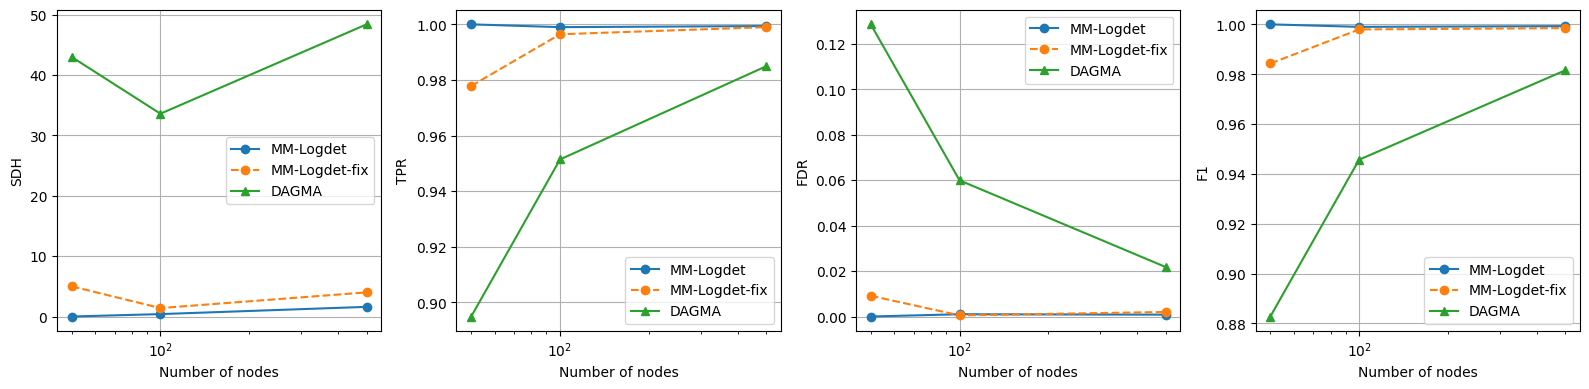

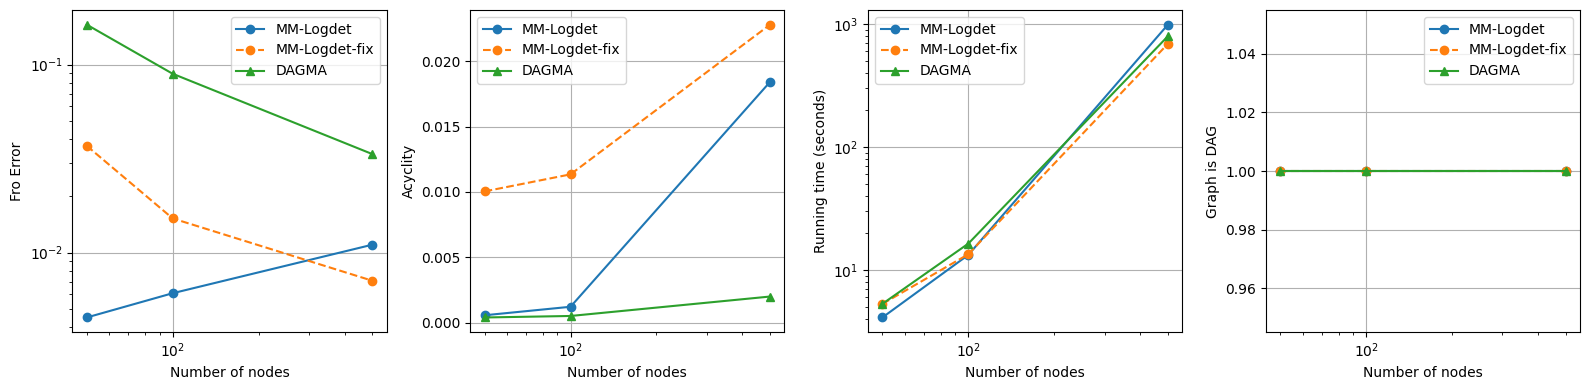

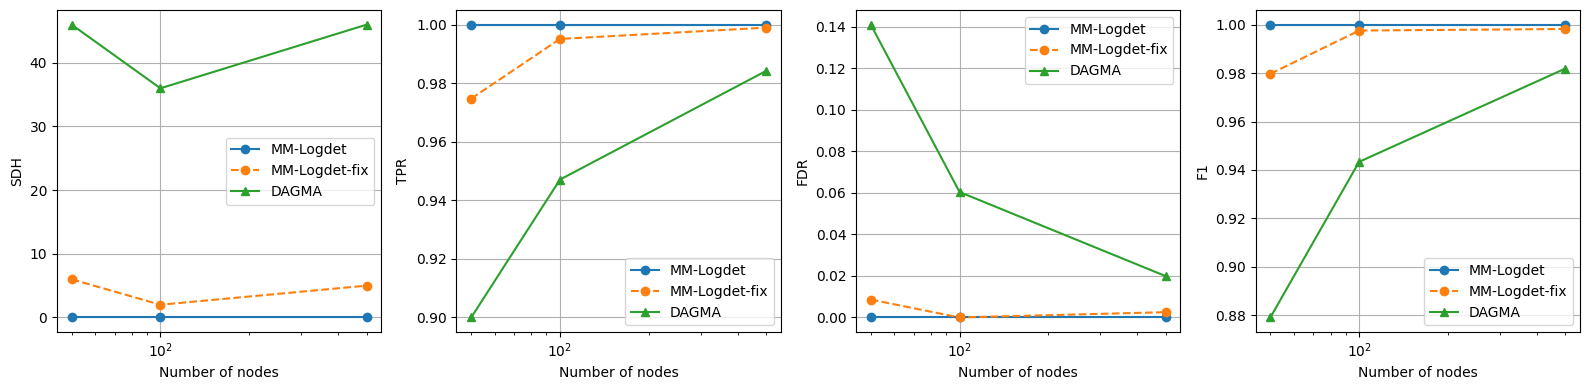

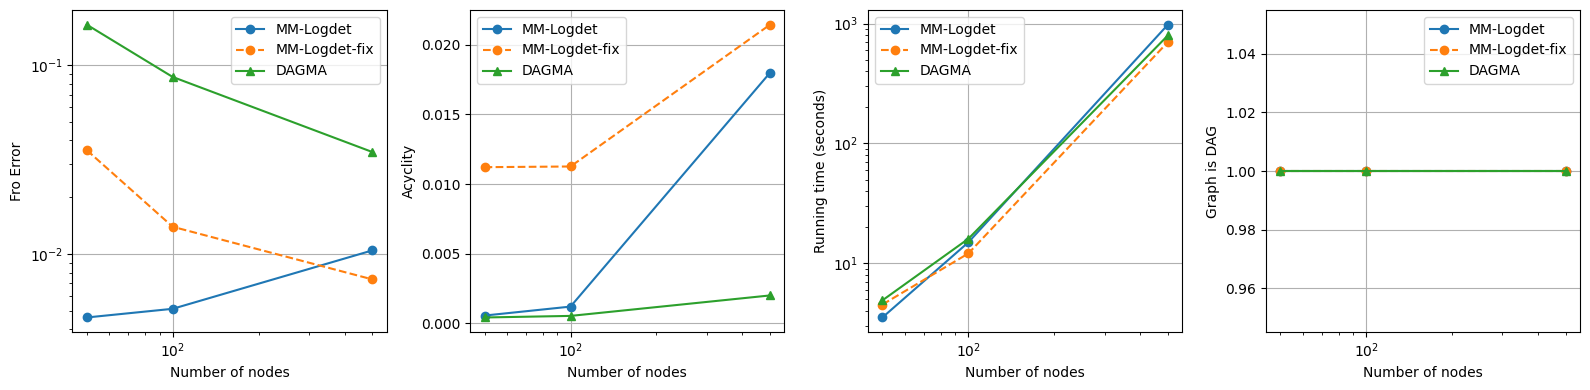

In [ ]:
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results_er4)

if SAVE:
    file_name = PATH + f'size_ERgraph_{data_p["edges"]}N_samples'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='mean', xlabel='Number of nodes')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')


### Scale free

In [ ]:
N = 100
thr = .2
verb = False
data_p = {
    # 'n_nodes': N,
    'graph_type': 'sf',
    'edges': 2,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
    'n_samples': None,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_sf4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

CPUs employed: 64
Graph: 1, n_nodes: 50
Graph: 2, n_nodes: 50
Graph: 3, n_nodes: 50
Graph: 5, n_nodes: 50
Graph: 4, n_nodes: 50
Graph: 3, n_nodes: 100
Graph: 5, n_nodes: 100
Graph: 1, n_nodes: 100
Graph: 2, n_nodes: 100
Graph: 4, n_nodes: 100
Graph: 4, n_nodes: 500
Graph: 5, n_nodes: 500
Graph: 3, n_nodes: 500
Graph: 2, n_nodes: 500
Graph: 1, n_nodes: 500
----- Solved in 115.621 minutes -----


SAVED in file: ./results/size/size_SFgraph_4N


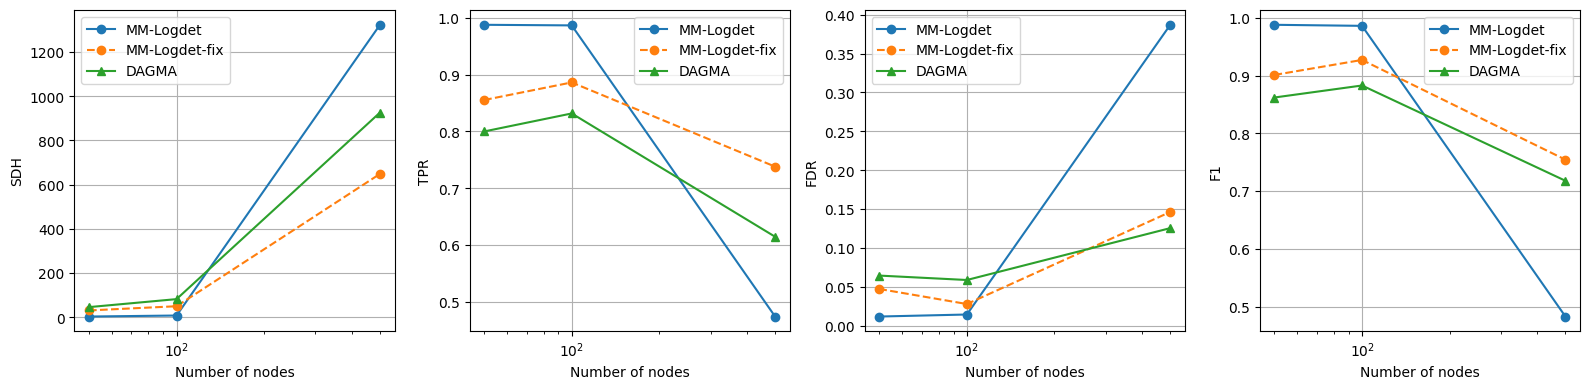

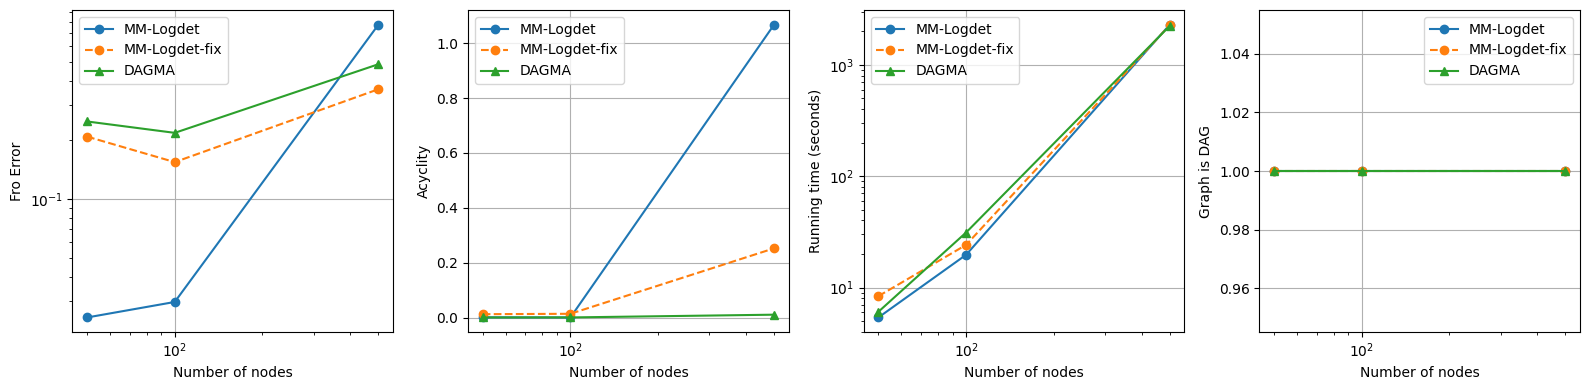

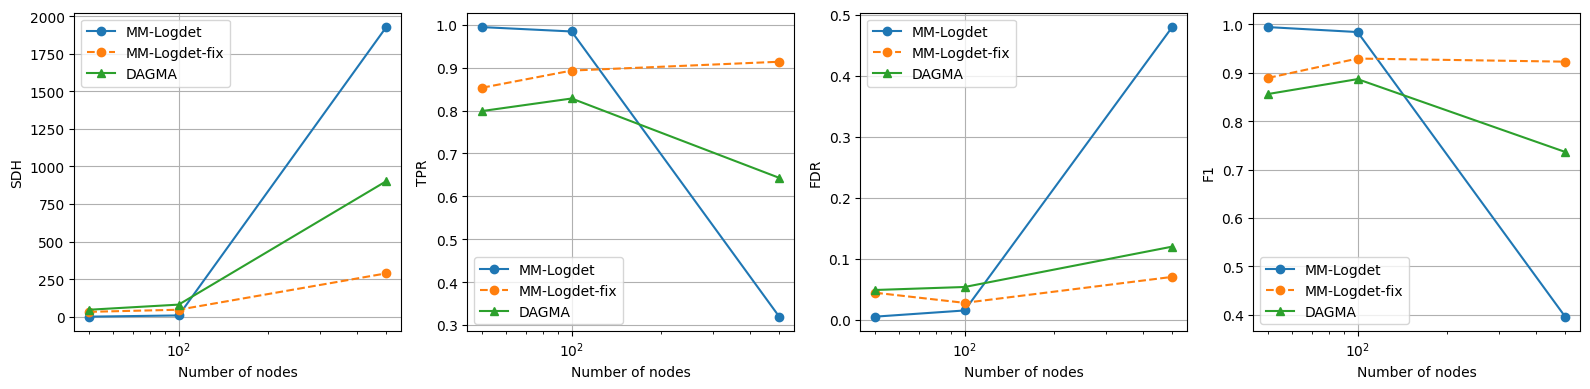

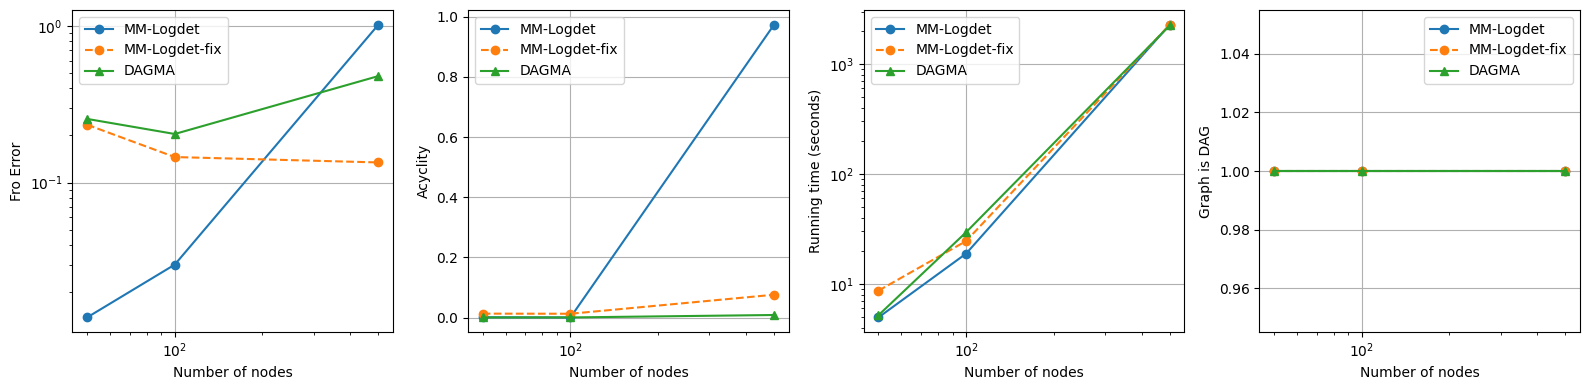

In [ ]:
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results_sf4)

if SAVE:
    file_name = PATH + f'size_SFgraph_{data_p["edges"]}N_samples'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='mean', xlabel='Number of nodes')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')
